In [1]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt
from IPython import display

# 街景分割 (pytorch)

支援python 版本: 3.5以上    
支援pytorch版本 : 1.2以上

許多人小時候都曾經幻想過自己是霹靂遊俠的李麥克，能夠有一台自動駕駛的「夥計」，而如今這個夢想已經不算是太遙遠，我們今天要做的實作就是教各位如何賦予汽車視覺，最普遍的做法是透過分割模型，將機器視野的圖片進行分割，並且針對各區域進行識別，這樣汽車才知道路在那裏，哪裡有行人得小心注意。下圖是我們這次實作所使用的原圖以及標注結果。 

In [2]:
import os
os.environ['TRIDENT_BACKEND'] = 'pytorch'
#!pip install tridentx --upgrade
import trident as T
from trident import *
from trident.models import densenet


trident 0.5.0
Using Pytorch backend.
Image Data Format: channels_first.
Image Channel Order: rgb.
Pytorch version:1.4.0.
Using pillow image backend.
Pillow version:6.2.1.


這次採用的數據集是Cambridge-driving Labeled Video Database (http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/ )，他實際上就是真實的汽車駕駛過程的街景，裏面包含了原圖已經標註的遮罩圖(mask)。

<img src="../images/streetview_image.png">
<img src="../images/streetview_mask.png">

In [3]:
data_provider=load_examples_data('autodrive')
data_provider.paired_transform_funcs=[random_rescale_crop(224, 224,scale=(0.3,1.1))]
data_provider.image_transform_funcs=[
                     add_noise(0.01),
                     random_adjust_gamma(gamma=(0.8,1.2)),
                     random_adjust_contrast(scale=(0.9, 1.1)),
                     normalize(0,255),
                     normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])]

archive file is already existing, donnot need download again.
extraction is finished, donnot need extract again.
get autodrive images :701


所有標注類別對應的顏色，紀錄在label_colors.txt中(可以在~\.trident\datasets\examples_autodrive目錄下找到)，我們讀取出來並且產生定義清單。這邊顏色的排序為(R,G,B)，與我們的圖片標準一致，若是您另外使用opencv處理數據，則需要自行轉換順序，例如路面上的汽車是紫色，opencv的BGR應該是(128,0,64)。在trident api中，Mask類的數據來源有專用的MaskDataset，它可以處理二元遮罩、標籤遮罩(基於索引值區分類別)以及色彩遮罩(基於顏色區分類別)，在這個範例中正是色彩遮罩，透過MaskDataset讀取色彩遮罩圖片，會自動處理將它轉換為對於建模有用的標籤遮罩。自動處理主要是調用了trident.data.mask_common中的color2label以及label2color函數。

In [4]:
print(data_provider.traindata.palette)

OrderedDict([('Void', (0, 0, 0)), ('Building', (128, 0, 0)), ('Tree', (128, 128, 0)), ('Sky', (128, 128, 128)), ('Car', (64, 0, 128)), ('Archway', (192, 0, 128)), ('SignSymbol', (192, 128, 128)), ('Road', (128, 64, 128)), ('Pedestrian', (64, 64, 0)), ('Wall', (64, 192, 0)), ('VegetationMisc', (192, 192, 0)), ('Fence', (64, 64, 128)), ('Train', (192, 64, 128)), ('ParkingBlock', (64, 192, 128)), ('Column_Pole', (192, 192, 128)), ('TrafficCone', (0, 0, 64)), ('Bridge', (0, 128, 64)), ('Misc_Text', (128, 128, 64)), ('Sidewalk', (0, 0, 192)), ('LaneMkgsDriv', (128, 0, 192)), ('Bicyclist', (0, 128, 192)), ('RoadShoulder', (128, 128, 192)), ('Tunnel', (64, 0, 64)), ('LaneMkgsNonDriv', (192, 0, 64)), ('Animal', (64, 128, 64)), ('Child', (192, 128, 64)), ('CartLuggagePram', (64, 0, 192)), ('MotorcycleScooter', (192, 0, 192)), ('SUVPickupTruck', (64, 128, 192)), ('Truck_Bus', (192, 128, 192)), ('TrafficLight', (0, 64, 64)), ('OtherMoving', (128, 64, 64))])


定義fcn-densenet，也就是俗稱的提拉米蘇。基本上它是以Densenet為基礎，總共包含兩個路徑，一個是逐步進行下採樣讓圖片縮小(TD,  transition down)，另外一個路徑則是逐步將縮小的圖片進行上採樣來復原(TU, transition up)，在尺寸對應的的層，會透過skip connection將較完整清晰的特徵從TD路徑傳至TU路徑，以確保細節特徵的完整性。

<img src="../images/dense_connection.png">

<img src="../images/tiramisu.jpg">

由於我們這次並沒有使用預訓練模型來做微調，必須從零開始，那意味著我們需要花更多的訓練資源才能做到一樣的效果，但我們這次又有一個限制是數據集只有701張圖片，在沒有預訓練又圖片數量少(還好圖片標註品質很好)，就必須從模型結構設計下手才有可能做到較好的預測效果。以下是我針對這樣的情況做的一些調整：  
1. 使用DenseNetFcn就是一個較佳的選擇，因為DenseNet強調的是特徵的重複使用，整個網路中不斷地進行特徵篩選、特徵重新加入，以及各種尺度特徵的混合，所以利用這樣的網路結構比較不容易發生過擬合。  
2. 過擬合很容易發生的一個主因是使用了與數據不相襯的參數規模，尤其是越複雜(參數越多的網路)只能靠更龐大的數據集才有可能訓練的好，也因此，原始論文的tiramisu 103的blocks參數是(4,5,7,10,12,15)我把它下調到(4, 5, 6, 7, 8)，原本原始參數TransitionDown共使用了5次(len(blocks)-1)，我則是使用4次，然後讓第一層的卷積透過strides=2分擔掉一次下採樣的任務，這樣也可以減少非常大量的計算量。
3. 原本的TransitionDown是利用一個3x3常規卷積搭配MaxPool，基本上我們課程介紹過，使用池化是比較古老的做法了，現在都建議使用Strides=2來替代池化。此外，為了降低計算量，我把常規卷積置換為Depthwise卷積，也可以大幅縮小計算的參數數量。同時也加入了0.2的dropout，以增加模型的強健程度避免過擬合。
4. 數據增強中把random_center_crop換成了random_rescale_crop，在之前實作「去背神器」中是一個二分類的分割模型，因此如果crop剛好沒有人的出現就會影響訓練，所以使用random_center_crop來確保人會出現在取數的範圍。但是現在這是一個32分類的問題，基本上不管切到哪裡都會有要預測的類別，使用random_rescale_crop的好處在於可以聚焦在不同的區域而非僅是中心點，這樣可以保證取出來的結果的多元性，有可以緩解模型總是預測最大積率類別的問題。
5. 使用了多損失函數策略。一開始先用DiceLoss這種基於類別的損失函數來達到快速的損失下降(多分類的DiceLoss是計算每個類別的損失後平均，因此本身是不易受到分布不均衡影響)，但是DiceLoss雖然能讓整體模型有快速收斂的效果，卻無法作精細的調整，所以還需要同時加入損失函數CrossEntropyLoss來做細部的調整，但由於CrossEntropyLoss是計算每顆像素的CrossEntropyLoss後平均，因此會嚴重受到類別不均衡的影響。所以最後在第5個epoch後加入FocalLoss，來處理最後類別不均衡的分類錯誤。這樣分層次的多損失函數策略可以讓模型分階段調整，以確保模型整體效果。
6. 學習速率一開始就使用偏小的5e-4，確保收斂不至於衝太快避免掉入區域最佳解的問題。


In [5]:
tiramisu=densenet.DenseNetFcn(blocks=(4, 5, 6, 7, 8),growth_rate=16, initial_filters=32,num_classes=32)

#tiramisu.load_model('Models/tiramisu.pth.tar')

In [6]:
tiramisu.with_optimizer(optimizer='Ranger',lr=5e-4,betas=(0.9, 0.999))\
    .with_loss(DiceLoss)\
    .with_loss(CrossEntropyLoss)\
    .with_loss(FocalLoss,2,start_epoch=5)\
    .with_metric(pixel_accuracy,name='pixel_accuracy')\
    .with_metric(iou,name='iou')\
    .with_regularizer('l2')\
    .with_constraint('max_min_norm')\
    .with_learning_rate_scheduler(reduce_lr_on_plateau,monitor='iou',mode='max',factor=0.5,patience=3,cooldown=2,threshold=5e-4,warmup=0)\
    .with_model_save_path('Models/tiramisu_1.pth')\
    .with_callbacks(SegTileImageCallback(batch_inteval=20,reverse_image_transform=data_provider.reverse_image_transform,palette=data_provider.traindata.palette))

#在模型中設定
#with_optimizer 設定優化器為Ranger
#with_loss(DiceLoss) 加入Dice loss損失函數(類別層級)
#with_loss(CrossEntropyLoss)加入交叉熵作為損失函數(像素層級)
#with_loss(FocalLoss,start_epoch=5)加入FocalLoss作為損失函數(像素層級)解決類別不均衡問題，於epoch=5時開始納入計算
#with_metric(pixel_accuracy) 加入像素正確率metrics
#with_metric(iou,name='iou') 加入iou作為metrics
#with_regularizer('l2')\ 加入l2正則
#with_constraint('max_min_norm')\ 加入max_min_norm權重正則
#with_learning_rate_scheduler(reduce_lr_on_plateau) 加入reduce_lr_on_plateau學習率變化原則(指標不再變動時，學習率下降)
#with_model_save_path('Models/deeplab_seg.pth') 設定模型存檔路徑
#with_callbacks 加入SegTileImageCallback來繪製比較用的tile images

tiramisu.summary()

DiceLoss signature:[('output', [32, 224, 224]), ('target', [32, 224, 224])]
CrossEntropyLoss signature:[('output', [32, 224, 224]), ('target', [32, 224, 224])]
FocalLoss signature:[('output', [32, 224, 224]), ('target', [32, 224, 224])]
pixel_accuracy signature:[('output', [32, 224, 224]), ('target', [32, 224, 224])]
iou signature:[('output', [32, 224, 224]), ('target', [32, 224, 224])]
--------------------------------------------------------------------------------------------------------------------------------
              Layer (type)                   Output Shape            Weight           Bias    Param #     FLOPS #   
first_layer                              [-1, 32, 112, 112]                                   0         0.0         
batch_norm_1                             [-1, 32, 112, 112]    [32]                 [32]      64        1191680.0   
norm                                     [-1, 256, 112, 112]   [256]                [256]     512       9621248.0   
relu         

In [7]:
plan=TrainingPlan()\
    .add_training_item(tiramisu,name='tiramisu')\
    .with_data_loader(data_provider)\
    .repeat_epochs(15)\
    .within_minibatch_size(6)\
    .print_progress_scheduling(5,unit='batch')\
    .display_loss_metric_curve_scheduling(frequency=50,unit='batch',imshow=True)\
    .save_model_scheduling(20,unit='batch')\

#add_training_item加入要訓練的模型
#with_data_loader加入數據提供者
#repeat_epochs設定要執行的epoch數量
#within_minibatch_size設定minibatch_size
#print_progress_scheduling設定列印進度的頻率
#display_loss_metric_curve_scheduling設定顯示損失函數曲線的頻率
#save_model_scheduling設定存檔的頻率

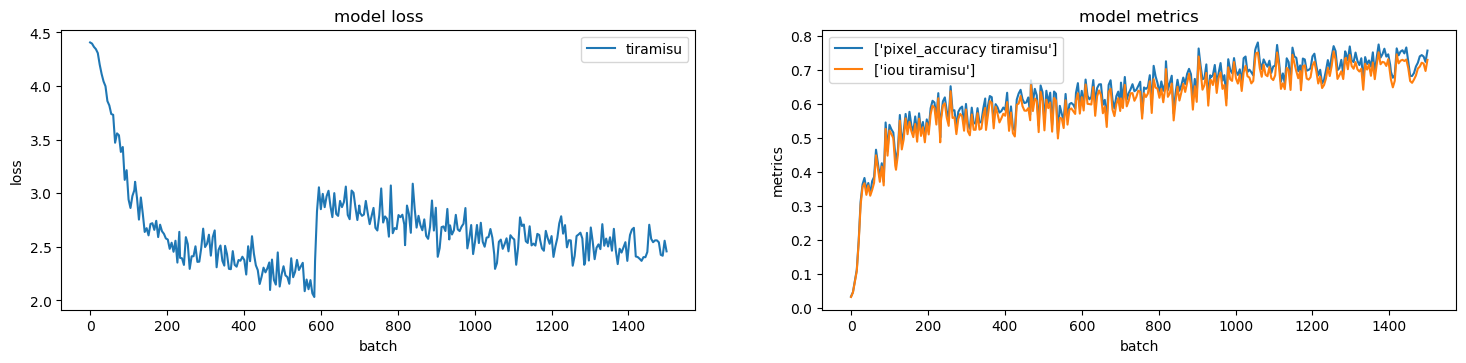

tiramisu     Step: 26s54ms  | Loss: 2.474   | pixel_accuracy: 74.290% ,iou: 71.144%  | learning rate: 5.000e-04 | epoch: 12  ( 100/117 )


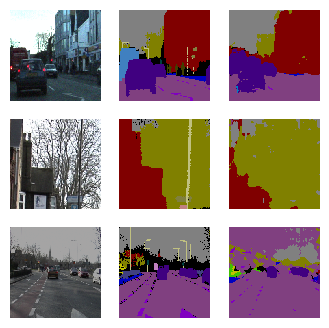

tiramisu     Step: 25s136ms | Loss: 2.373   | pixel_accuracy: 77.237% ,iou: 73.491%  | learning rate: 5.000e-04 | epoch: 12  ( 105/117 )
tiramisu     Step: 23s150ms | Loss: 2.534   | pixel_accuracy: 72.001% ,iou: 69.996%  | learning rate: 5.000e-04 | epoch: 12  ( 110/117 )
tiramisu     Step: 16s198ms | Loss: 2.337   | pixel_accuracy: 77.288% ,iou: 75.192%  | learning rate: 5.000e-04 | epoch: 12  ( 115/117 )
tiramisu     Step: 6s285ms  | Loss: 2.370   | pixel_accuracy: 73.162% ,iou: 70.836%  | learning rate: 5.000e-04 | epoch: 13  ( 0/117 )
OrderedDict([('total_losses', 2.3701783418655396), ('DiceLoss', 0.5466546416282654), ('CrossEntropyLoss', 0.658967137336731), ('l2_reg_Loss', 5.670087375619914e-06), ('FocalLoss', 0.9220662117004395)])


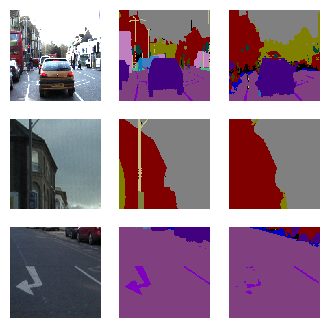

tiramisu     Step: 24s307ms | Loss: 2.488   | pixel_accuracy: 75.523% ,iou: 71.744%  | learning rate: 5.000e-04 | epoch: 13  ( 5/117 )
tiramisu     Step: 24s381ms | Loss: 2.513   | pixel_accuracy: 72.727% ,iou: 70.256%  | learning rate: 5.000e-04 | epoch: 13  ( 10/117 )
tiramisu     Step: 17s238ms | Loss: 2.890   | pixel_accuracy: 67.726% ,iou: 65.695%  | learning rate: 5.000e-04 | epoch: 13  ( 15/117 )
tiramisu     Step: 15s194ms | Loss: 2.327   | pixel_accuracy: 77.594% ,iou: 74.908%  | learning rate: 5.000e-04 | epoch: 13  ( 20/117 )


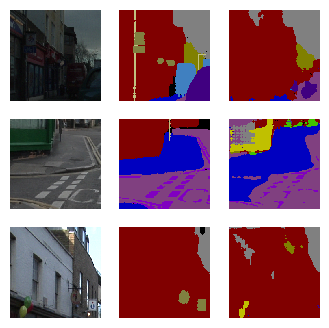

tiramisu     Step: 16s733ms | Loss: 2.427   | pixel_accuracy: 74.251% ,iou: 70.788%  | learning rate: 5.000e-04 | epoch: 13  ( 25/117 )
tiramisu     Step: 15s262ms | Loss: 2.359   | pixel_accuracy: 74.169% ,iou: 72.668%  | learning rate: 5.000e-04 | epoch: 13  ( 30/117 )
tiramisu     Step: 15s546ms | Loss: 2.370   | pixel_accuracy: 75.316% ,iou: 73.269%  | learning rate: 5.000e-04 | epoch: 13  ( 35/117 )
tiramisu     Step: 13s866ms | Loss: 2.380   | pixel_accuracy: 76.089% ,iou: 74.178%  | learning rate: 5.000e-04 | epoch: 13  ( 40/117 )


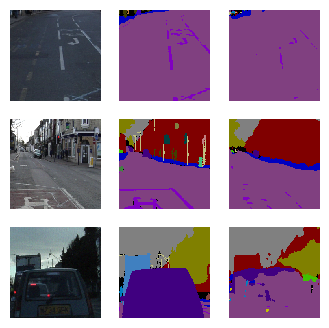

tiramisu     Step: 15s854ms | Loss: 2.459   | pixel_accuracy: 75.006% ,iou: 71.761%  | learning rate: 5.000e-04 | epoch: 13  ( 45/117 )


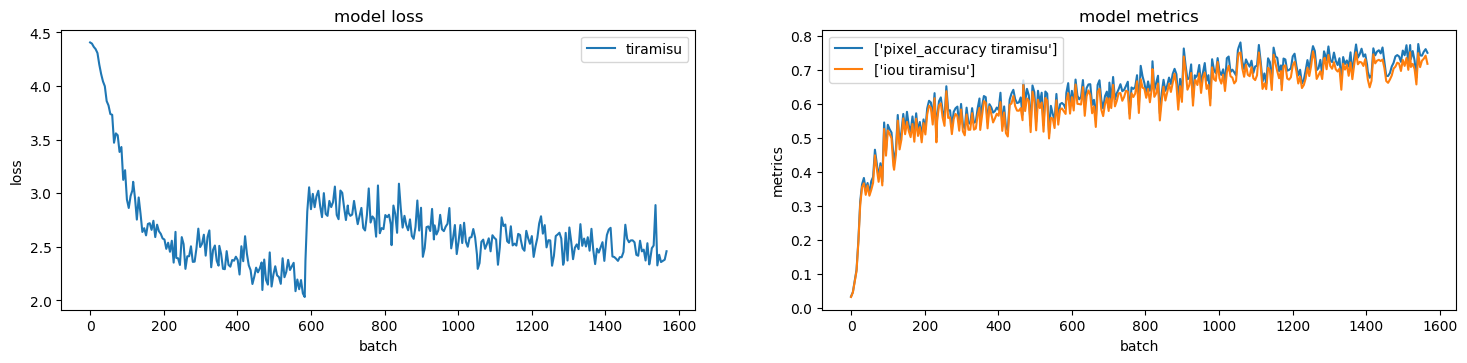

tiramisu     Step: 15s639ms | Loss: 2.559   | pixel_accuracy: 70.832% ,iou: 68.918%  | learning rate: 5.000e-04 | epoch: 13  ( 50/117 )
tiramisu     Step: 14s447ms | Loss: 2.401   | pixel_accuracy: 76.582% ,iou: 74.812%  | learning rate: 5.000e-04 | epoch: 13  ( 55/117 )
tiramisu     Step: 15s691ms | Loss: 2.487   | pixel_accuracy: 73.288% ,iou: 69.811%  | learning rate: 5.000e-04 | epoch: 13  ( 60/117 )


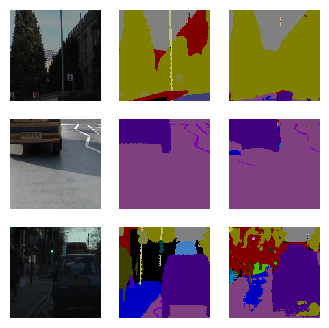

tiramisu     Step: 17s820ms | Loss: 2.498   | pixel_accuracy: 74.531% ,iou: 71.852%  | learning rate: 5.000e-04 | epoch: 13  ( 65/117 )
tiramisu     Step: 17s431ms | Loss: 2.507   | pixel_accuracy: 71.618% ,iou: 69.692%  | learning rate: 5.000e-04 | epoch: 13  ( 70/117 )
tiramisu     Step: 15s584ms | Loss: 2.546   | pixel_accuracy: 75.072% ,iou: 72.158%  | learning rate: 5.000e-04 | epoch: 13  ( 75/117 )
tiramisu     Step: 15s566ms | Loss: 2.433   | pixel_accuracy: 73.713% ,iou: 71.098%  | learning rate: 5.000e-04 | epoch: 13  ( 80/117 )


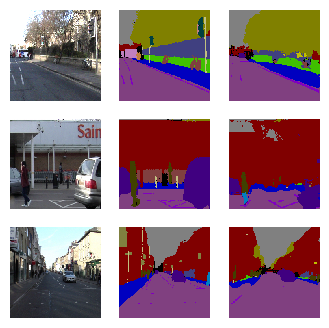

tiramisu     Step: 19s110ms | Loss: 2.622   | pixel_accuracy: 73.079% ,iou: 70.686%  | learning rate: 5.000e-04 | epoch: 13  ( 85/117 )
tiramisu     Step: 19s40ms  | Loss: 2.557   | pixel_accuracy: 70.794% ,iou: 67.807%  | learning rate: 5.000e-04 | epoch: 13  ( 90/117 )
tiramisu     Step: 21s699ms | Loss: 2.409   | pixel_accuracy: 76.178% ,iou: 73.319%  | learning rate: 5.000e-04 | epoch: 13  ( 95/117 )


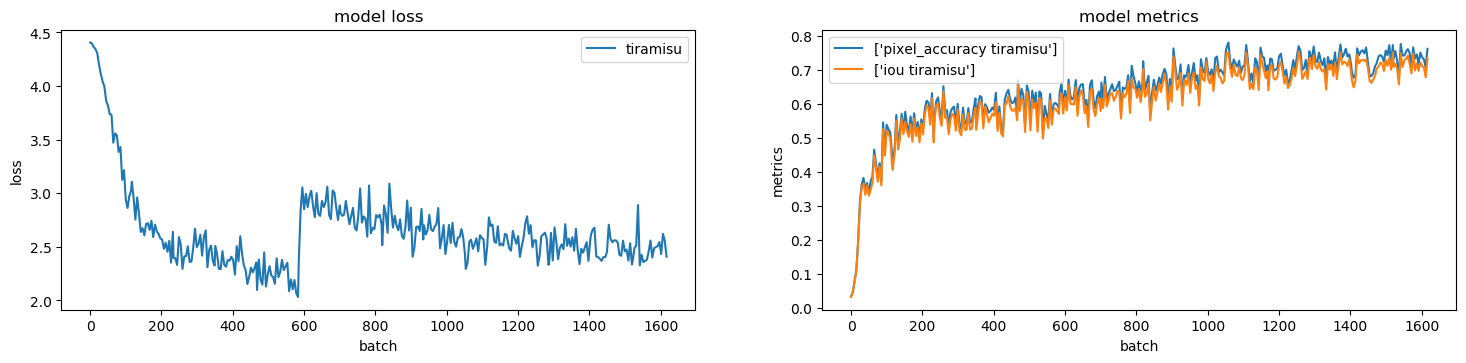

tiramisu     Step: 18s383ms | Loss: 2.334   | pixel_accuracy: 77.998% ,iou: 74.587%  | learning rate: 5.000e-04 | epoch: 13  ( 100/117 )


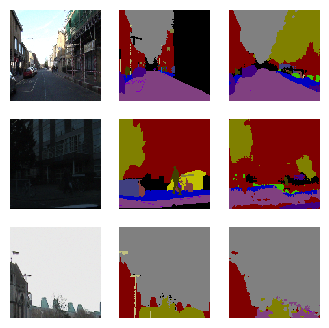

tiramisu     Step: 17s712ms | Loss: 2.299   | pixel_accuracy: 78.598% ,iou: 76.589%  | learning rate: 5.000e-04 | epoch: 13  ( 105/117 )
tiramisu     Step: 16s214ms | Loss: 2.467   | pixel_accuracy: 73.057% ,iou: 71.788%  | learning rate: 5.000e-04 | epoch: 13  ( 110/117 )
tiramisu     Step: 17s865ms | Loss: 2.427   | pixel_accuracy: 75.678% ,iou: 74.064%  | learning rate: 5.000e-04 | epoch: 13  ( 115/117 )
tiramisu     Step: 7s472ms  | Loss: 2.636   | pixel_accuracy: 75.205% ,iou: 70.446%  | learning rate: 5.000e-04 | epoch: 14  ( 0/117 )
OrderedDict([('total_losses', 2.635939359664917), ('DiceLoss', 0.5375068187713623), ('CrossEntropyLoss', 1.3518437147140503), ('l2_reg_Loss', 5.67030565434834e-06), ('FocalLoss', 0.9312857985496521)])


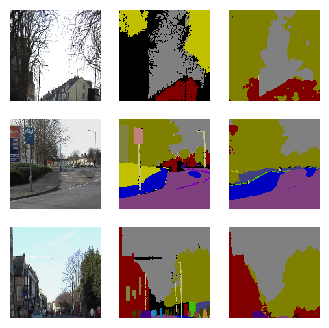

tiramisu     Step: 20s456ms | Loss: 2.633   | pixel_accuracy: 72.850% ,iou: 70.596%  | learning rate: 5.000e-04 | epoch: 14  ( 5/117 )
tiramisu     Step: 18s523ms | Loss: 2.498   | pixel_accuracy: 75.023% ,iou: 71.807%  | learning rate: 5.000e-04 | epoch: 14  ( 10/117 )
tiramisu     Step: 17s379ms | Loss: 2.283   | pixel_accuracy: 79.844% ,iou: 78.145%  | learning rate: 5.000e-04 | epoch: 14  ( 15/117 )
tiramisu     Step: 17s262ms | Loss: 2.137   | pixel_accuracy: 82.425% ,iou: 80.875%  | learning rate: 5.000e-04 | epoch: 14  ( 20/117 )


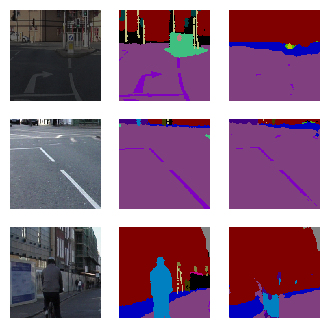

tiramisu     Step: 18s405ms | Loss: 2.416   | pixel_accuracy: 73.703% ,iou: 70.875%  | learning rate: 5.000e-04 | epoch: 14  ( 25/117 )
tiramisu     Step: 12s920ms | Loss: 2.463   | pixel_accuracy: 74.734% ,iou: 72.081%  | learning rate: 5.000e-04 | epoch: 14  ( 30/117 )
tiramisu     Step: 14s757ms | Loss: 2.396   | pixel_accuracy: 76.033% ,iou: 74.559%  | learning rate: 5.000e-04 | epoch: 14  ( 35/117 )
tiramisu     Step: 21s204ms | Loss: 2.402   | pixel_accuracy: 74.847% ,iou: 73.150%  | learning rate: 5.000e-04 | epoch: 14  ( 40/117 )


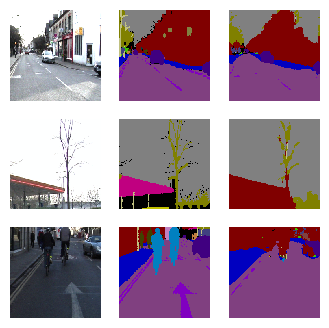

tiramisu     Step: 26s280ms | Loss: 2.496   | pixel_accuracy: 75.463% ,iou: 72.512%  | learning rate: 5.000e-04 | epoch: 14  ( 45/117 )


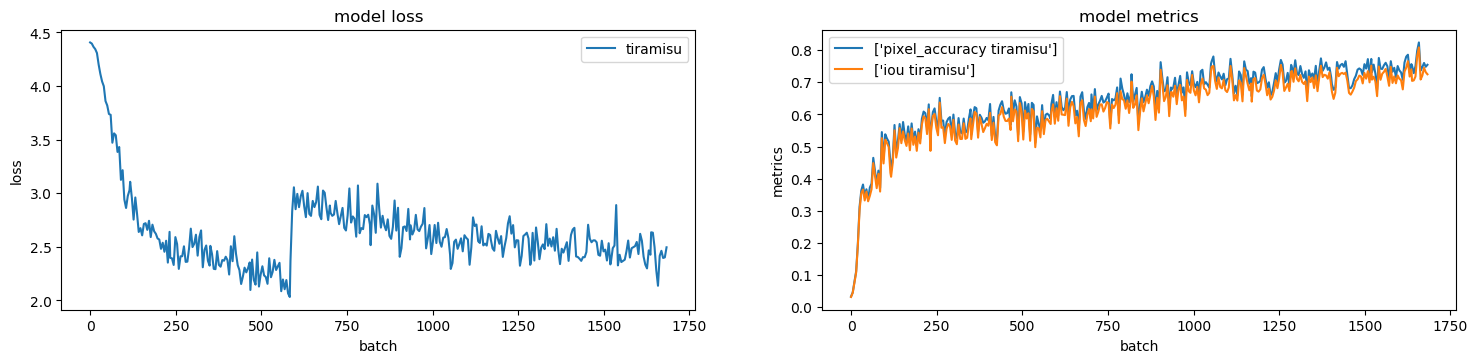

tiramisu     Step: 20s366ms | Loss: 2.201   | pixel_accuracy: 80.798% ,iou: 77.428%  | learning rate: 5.000e-04 | epoch: 14  ( 50/117 )
tiramisu     Step: 14s365ms | Loss: 2.236   | pixel_accuracy: 78.295% ,iou: 76.278%  | learning rate: 5.000e-04 | epoch: 14  ( 55/117 )
tiramisu     Step: 14s970ms | Loss: 2.506   | pixel_accuracy: 73.110% ,iou: 70.309%  | learning rate: 5.000e-04 | epoch: 14  ( 60/117 )


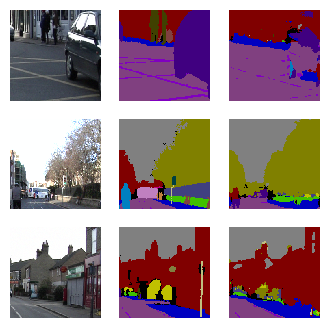

tiramisu     Step: 14s466ms | Loss: 2.452   | pixel_accuracy: 75.166% ,iou: 72.322%  | learning rate: 5.000e-04 | epoch: 14  ( 65/117 )
tiramisu     Step: 14s263ms | Loss: 2.399   | pixel_accuracy: 75.181% ,iou: 73.465%  | learning rate: 5.000e-04 | epoch: 14  ( 70/117 )
tiramisu     Step: 13s586ms | Loss: 2.227   | pixel_accuracy: 80.084% ,iou: 78.283%  | learning rate: 5.000e-04 | epoch: 14  ( 75/117 )
tiramisu     Step: 13s672ms | Loss: 2.445   | pixel_accuracy: 76.252% ,iou: 73.585%  | learning rate: 5.000e-04 | epoch: 14  ( 80/117 )


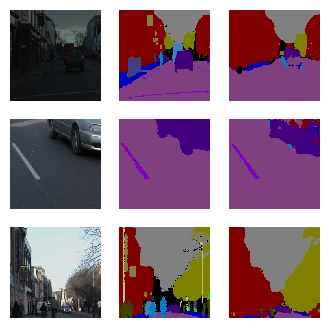

tiramisu     Step: 14s625ms | Loss: 2.544   | pixel_accuracy: 72.323% ,iou: 69.313%  | learning rate: 5.000e-04 | epoch: 14  ( 85/117 )
tiramisu     Step: 11s985ms | Loss: 2.326   | pixel_accuracy: 77.313% ,iou: 74.548%  | learning rate: 5.000e-04 | epoch: 14  ( 90/117 )
tiramisu     Step: 12s368ms | Loss: 2.640   | pixel_accuracy: 72.634% ,iou: 69.950%  | learning rate: 5.000e-04 | epoch: 14  ( 95/117 )


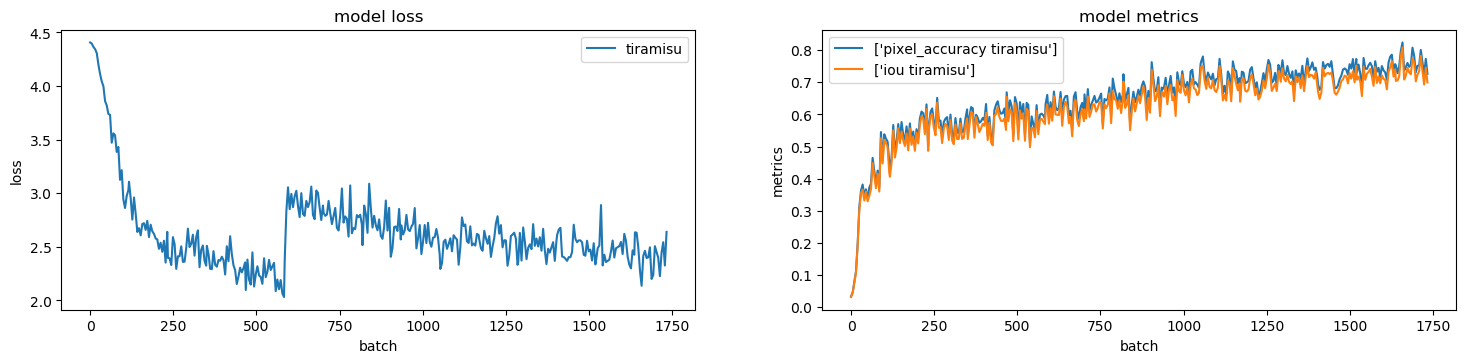

tiramisu     Step: 13s719ms | Loss: 2.435   | pixel_accuracy: 75.501% ,iou: 72.089%  | learning rate: 5.000e-04 | epoch: 14  ( 100/117 )


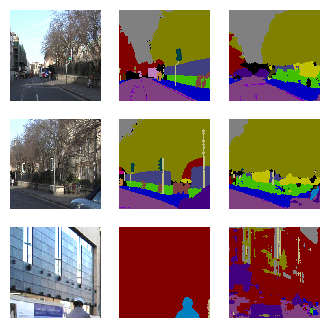

tiramisu     Step: 13s791ms | Loss: 2.496   | pixel_accuracy: 72.435% ,iou: 70.603%  | learning rate: 5.000e-04 | epoch: 14  ( 105/117 )
tiramisu     Step: 13s925ms | Loss: 2.401   | pixel_accuracy: 74.705% ,iou: 73.219%  | learning rate: 5.000e-04 | epoch: 14  ( 110/117 )
tiramisu     Step: 13s323ms | Loss: 2.289   | pixel_accuracy: 78.304% ,iou: 75.976%  | learning rate: 5.000e-04 | epoch: 14  ( 115/117 )


In [8]:
plan.start_now()